In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils
# from tensorflow.keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Get Features data from compressed file

In [2]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_x.npz')
# extract the first array
X = dict_data['arr_0']
# print the array
print(X)


[[ 7.61570786e-02  6.56093121e-01  6.97486043e-01 ... -5.49116870e-02
   8.43622550e-03  8.68360564e-03]
 [ 3.19148516e-01  7.88175575e-01  7.97310264e-01 ... -4.54879980e-02
   6.22307115e-03  3.68944098e-03]
 [ 7.96194366e-02  7.41017640e-01  6.35196090e-01 ... -6.75728546e-02
   1.07973404e-02 -1.56228028e-02]
 ...
 [ 4.21099154e-02  6.06974602e-01  6.26703024e-01 ... -8.72499610e-03
  -2.71237992e-04  8.32928067e-03]
 [ 4.41170794e-02  6.30543611e-01  6.68172135e-01 ... -1.16808890e-02
  -2.20377119e-03  8.63203886e-03]
 [ 4.50589025e-02  5.49822748e-01  5.96909761e-01 ...  1.06826018e-02
   6.74372531e-03 -6.59982994e-03]]


In [3]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_y.npz')
# extract the first array
Y = dict_data['arr_0']
# print the array
print(Y)


['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [4]:
X.shape, Y.shape


((36621, 187), (36621,))

In [5]:
Features = pd.DataFrame(X)
Features['labels'] = Y

Features.shapeFeatures = pd.DataFrame(X)
Features['labels'] = Y

Features.shape


(36621, 188)

In [6]:
Features.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,labels
0,0.076157,0.656093,0.697486,0.684813,0.680425,0.670918,0.575612,0.571766,0.629165,0.661047,...,19.071780,18.205848,64.143048,0.011220,0.014544,-0.039381,-0.054912,0.008436,0.008684,angry
1,0.319149,0.788176,0.797310,0.812976,0.829499,0.847087,0.707635,0.653075,0.712158,0.703063,...,15.328932,14.800526,13.616032,0.007847,0.007250,-0.010280,-0.045488,0.006223,0.003689,angry
2,0.079619,0.741018,0.635196,0.690803,0.682903,0.649258,0.640377,0.538545,0.533444,0.604091,...,18.945783,18.753808,65.110960,-0.040476,-0.005076,0.060663,-0.067573,0.010797,-0.015623,angry
3,0.068002,0.714656,0.741048,0.658524,0.676285,0.686411,0.614934,0.584842,0.618500,0.691588,...,18.087724,17.060770,63.748496,-0.008231,-0.019454,-0.039172,-0.033343,0.011401,0.004871,disgust
4,0.158222,0.796261,0.801238,0.758541,0.789688,0.792804,0.685369,0.635259,0.666385,0.723402,...,15.605381,15.044415,14.347040,-0.000711,-0.010401,-0.049108,-0.020721,0.007966,0.010416,disgust


In [7]:
track_features = [
    ['ZCR', 1],
    ['Chroma_stft', 12],
    ['poly_features', 10],
    ['MFCC', 20],
    ['RMS', 1],
    ['MelSpectogram', 128],
    ['spectral centroid', 1],
    ['spectral rolloff', 1],
    ['spectral contrast', 7],
    ['tonnetz', 6]
]

column_tracker, temp = [0], 0
for data in track_features:
    temp += data[1]
    column_tracker.append(temp)

print("Total number of columns:", column_tracker[-1])

tracker = pd.DataFrame(track_features, columns=[
                       'Features', 'Number of Columns Occupied'])
tracker['Starts From'] = column_tracker[:-1]

tracker


Total number of columns: 187


,Features,Number of Columns Occupied,Starts From
0,ZCR,1,0
1,Chroma_stft,12,1
2,poly_features,10,13
3,MFCC,20,23
4,RMS,1,43
5,MelSpectogram,128,44
6,spectral centroid,1,172
7,spectral rolloff,1,173
8,spectral contrast,7,174
9,tonnetz,6,181


In [8]:
# Select the features that are to be removed by its index in the dataframe above
# To be given as comma separated values
to_remove = "0, 1, 3, 2"

to_remove = sorted(
    list(map(lambda x: int(x.strip()), to_remove.split(','))), reverse=True)

for num in to_remove:
    Features = Features.drop(
        Features.iloc[:, column_tracker[num]:column_tracker[num + 1]], axis=1)

Features.head()


,43,44,45,46,47,48,49,50,51,52,...,178,179,180,181,182,183,184,185,186,labels
0,0.040470,0.002945,0.005976,0.037027,0.264999,1.402992,2.726549,0.314069,0.240434,0.397594,...,19.071780,18.205848,64.143048,0.011220,0.014544,-0.039381,-0.054912,0.008436,0.008684,angry
1,0.045322,0.013702,0.016511,0.048771,0.284955,1.426173,2.748817,0.329858,0.243101,0.413642,...,15.328932,14.800526,13.616032,0.007847,0.007250,-0.010280,-0.045488,0.006223,0.003689,angry
2,0.024856,0.001152,0.002388,0.008347,0.101939,0.302163,1.128483,0.313687,0.105751,0.188728,...,18.945783,18.753808,65.110960,-0.040476,-0.005076,0.060663,-0.067573,0.010797,-0.015623,angry
3,0.015553,0.001829,0.006370,0.063853,0.336366,0.214143,0.120846,0.260546,0.486371,0.404602,...,18.087724,17.060770,63.748496,-0.008231,-0.019454,-0.039172,-0.033343,0.011401,0.004871,disgust
4,0.015856,0.002048,0.006866,0.064299,0.338483,0.215624,0.120624,0.260914,0.488951,0.407600,...,15.605381,15.044415,14.347040,-0.000711,-0.010401,-0.049108,-0.020721,0.007966,0.010416,disgust


## Model Training and Testing

In [9]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values


In [10]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()


In [11]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 144), (27465, 8), (9156, 144), (9156, 8))

In [12]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 144), (27465, 8), (9156, 144), (9156, 8))

In [13]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 144, 1), (27465, 8), (9156, 144, 1), (9156, 8))

In [14]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 36, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 128)          0

In [15]:
epochs = 100

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs,
                    validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/100
430/430 [==============================] - 88s 198ms/step - loss: 1.7238 - accuracy: 0.3024 - val_loss: 1.5491 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 2/100
430/430 [==============================] - 90s 209ms/step - loss: 1.5133 - accuracy: 0.3878 - val_loss: 1.3962 - val_accuracy: 0.4275 - lr: 0.0010
Epoch 3/100
430/430 [==============================] - 80s 186ms/step - loss: 1.4034 - accuracy: 0.4309 - val_loss: 1.3274 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 4/100
430/430 [==============================] - 81s 187ms/step - loss: 1.3536 - accuracy: 0.4478 - val_loss: 1.2828 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 5/100
430/430 [==============================] - 86s 200ms/step - loss: 1.3105 - accuracy: 0.4687 - val_loss: 1.2212 - val_accuracy: 0.5061 - lr: 0.0010
Epoch 6/100
430/430 [==============================] - 82s 190ms/step - loss: 1.2679 - accuracy: 0.4863 - val_loss: 1.1905 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 7/100
430/430 [=========================

In [16]:
import joblib
model_filename = "lstm.pkl"
joblib.dump(history.history, model_filename)


['lstm.pkl']

287/287 [==============================] - 8s 29ms/step - loss: 1.2125 - accuracy: 0.6421
Accuracy of our model on test data :  64.20926451683044 %


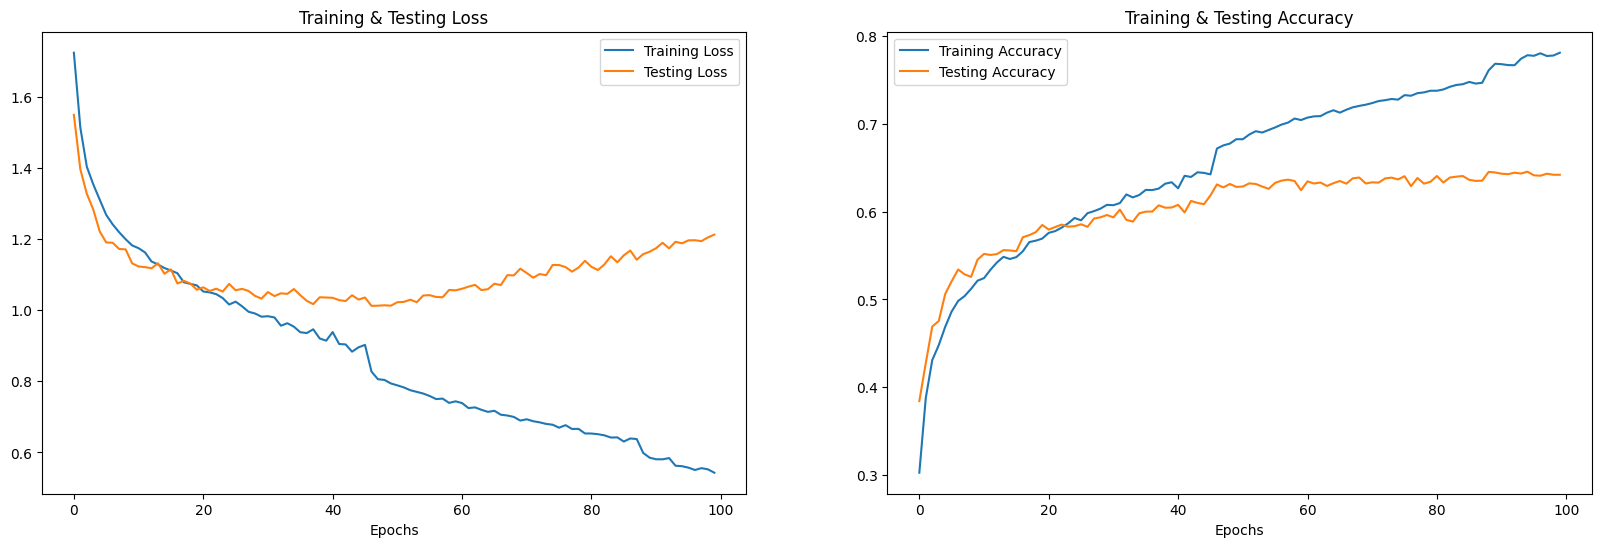

In [17]:
print("Accuracy of our model on test data : ",
      model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [18]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


287/287 [==============================] - 8s 27ms/step


In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


,Predicted Labels,Actual Labels
0,neutral,neutral
1,surprise,surprise
2,sad,disgust
3,angry,angry
4,disgust,disgust
5,neutral,disgust
6,angry,angry
7,disgust,disgust
8,sad,disgust
9,sad,sad


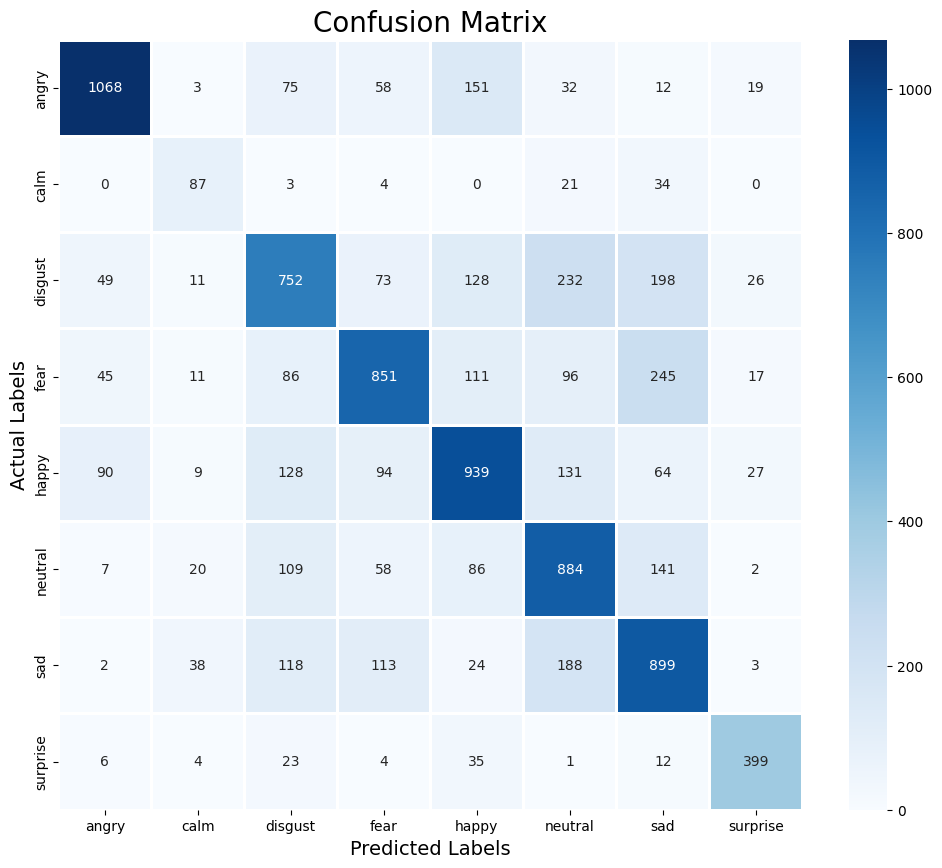

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
                  i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [21]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.84      0.75      0.80      1418
        calm       0.48      0.58      0.52       149
     disgust       0.58      0.51      0.54      1469
        fear       0.68      0.58      0.63      1462
       happy       0.64      0.63      0.64      1482
     neutral       0.56      0.68      0.61      1307
         sad       0.56      0.65      0.60      1385
    surprise       0.81      0.82      0.82       484

    accuracy                           0.64      9156
   macro avg       0.64      0.65      0.64      9156
weighted avg       0.65      0.64      0.64      9156

